# Introduction

This notebook focuses on **gold price forecasting** using a combination of baseline and deep learning models implemented in PyTorch. The project aims to predict future gold prices based on historical market data, enabling informed decision-making for trading and investment strategies.

The workflow includes:

* **Data Loading and Preprocessing** — Importing gold price data, applying statistical checks, scaling features, and generating technical indicators to enhance predictive power.
* **Feature Engineering** — Leveraging rolling statistical tests and custom transformations to capture temporal dynamics in gold price movements.
* **Model Development** — Implementing multiple architectures including:

  * **Baseline Model** — A simple average-based predictor for performance benchmarking.
  * **LSTM and GRU Networks** — Recurrent neural network models designed to capture sequential dependencies in time series data.
* **Training and Evaluation** — Applying a structured training/testing regime, integrating techniques such as early stopping, and comparing model performances against the baseline.

By establishing a robust comparison between naive prediction methods and advanced neural architectures, this notebook not only measures forecasting accuracy but also highlights the added value of deep learning for financial time series prediction.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 ! pip install ta
 ! pip install ptflops


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=092b491c08bd2cfde5b534c4a1671522dd8b3e53284c137d957ae834dc109dac
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


# import necessary packages

In [ ]:
import torch
from statsmodels.tsa.stattools import adfuller
from ptflops import get_model_complexity_info
import math
import seaborn as sns
import ta
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import torch.nn as nn
from copy import deepcopy
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
import random


# Load Data and preprocess

In [ ]:
def rolling_adf(df, col, window_size=30):
    """
    Calculate the Augmented Dickey-Fuller test statistic on a rolling window.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the column on which to perform the ADF test.
    col : str
        The name of the column on which to perform the ADF test.
    window_size : int
        The size of the rolling window.

    Returns:
    --------
    df_copy : pandas.DataFrame
        A new DataFrame with an additional column containing the rolling ADF test statistic.
    """
    df_copy = df.copy()

    # Create an empty series to store rolling ADF test statistic
    rolling_adf_stat = pd.Series(dtype='float64', index=df_copy.index)

    # Loop through the DataFrame by `window_size` and apply `adfuller`.
    for i in range(window_size, len(df)):
        window = df_copy[col].iloc[i-window_size:i]
        adf_result = adfuller(window)
        adf_stat = adf_result[0]
        rolling_adf_stat.at[df_copy.index[i]] = adf_stat

    # Add the rolling ADF test statistic series to the original DataFrame
    # df_copy['rolling_adf_stat'] = rolling_adf_stat

    return rolling_adf_stat




# Kaufman’s Adaptive Moving Average (KAMA)

def kama(df, col, n):
  df_copy = df.copy()
  # df_copy[f'kama_{n}'] = ta.momentum.KAMAIndicator(df_copy[col], n).kama()
  return ta.momentum.KAMAIndicator(df_copy[col], n).kama()

def moving_parkinson_estimator(df, window_size=10):

  def parkinson_estimator(df):
    N = len(df)
    sum_squared = np.sum(np.log(df['High'] / df['Low'])**2)
    volatility = math.sqrt((1/(4 * N * math.log(2))) * sum_squared)
    return volatility

  df_copy = df.copy()

  rolling_volatility = pd.Series(dtype='float64')

  for i in range(window_size, len(df)):
    window = df_copy.loc[df_copy.index[i-window_size] : df_copy.index[i]]
    volatility = parkinson_estimator(window)
    rolling_volatility.at[df_copy.index[i]] = volatility

  # df_copy['rolling_volatility_parkinson'] = rolling_volatility

  return rolling_volatility

def moving_yang_zhang_estimator(df, window_size=30):
    """
    Calculate Parkinson's volatility estimator based on high and low prices.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing 'high' and 'low' columns for each trading period.

    Returns:
    --------
    volatility : float
        Estimated volatility based on Parkinson's method.
    """
    def yang_zhang_estimator(df):
        N = len(window)

        term1 = np.log(window['High'] / window['Close']) * np.log(window['High'] / window['Open'])
        term2 = np.log(window['Low'] / window['Close']) * np.log(window['Low'] / window['Open'])

        sum_squared = np.sum(term1 + term2)
        volatility = np.sqrt(sum_squared / N)

        return volatility

    df_copy = df.copy()

    rolling_volatility = pd.Series(dtype='float64')

    for i in range(window_size, len(df)):
        window = df_copy.loc[df_copy.index[i-window_size]: df_copy.index[i]]
        volatility = yang_zhang_estimator(window)
        rolling_volatility.at[df_copy.index[i]] = volatility


    return rolling_volatility

def RSI(df, col, window_size):
  delta = df[col].diff(1)
  positive = delta.copy()
  negative = delta.copy()
  positive[positive < 0] = 0
  negative[negative > 0] = 0
  average_gain = positive.rolling(window=window_size).mean()
  average_loss = abs(negative.rolling(window=window_size).mean())
  relative_strength = average_gain / average_loss
  RSI = 100.0 - (100.0 - (1.0 + relative_strength))

  return RSI


def create_features(df, window_size=30):
  df['moving_parkinson'] = moving_parkinson_estimator(df, window_size=window_size)
  df['rolling_adf'] = rolling_adf(df, 'Price', window_size=window_size)
  df['moving_yang_zhang'] = moving_yang_zhang_estimator(df, window_size=window_size)
  df['kama'] =kama(df, 'Price', window_size)
  df['rsi'] = RSI(df, 'Price', window_size)
  return df

In [ ]:
pth = '/content/drive/MyDrive/MilliGold/data.xlsx'

df = pd.read_excel(pth, header=1, sheet_name='Data')

df['Timestamp'] = pd.to_timedelta(df['Day'], unit='d') + \
                pd.to_timedelta(df['Hour'], unit='h') + \
                pd.to_timedelta(df['Minute'], unit='m') + \
                pd.to_timedelta(df['Second'], unit='s')

In [ ]:
def remove_outliers(df):
  df1 = deepcopy(df)
  z_scores = (df1['Price.'] - df1['Price.'].mean()) / df1['Price.'].std()

  # Filter out rows where |z| > 2
  df_no_outliers = df1[np.abs(z_scores) <= 2.0]

  # Optional: reset index
  df_no_outliers = df_no_outliers.reset_index()

  return df_no_outliers



df_no_outliers = remove_outliers(df)

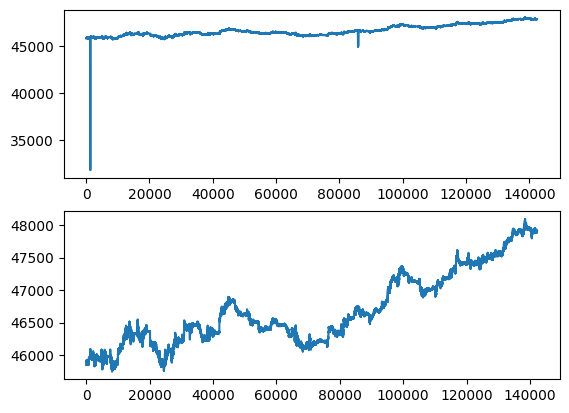

In [ ]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(df['Price.'])
axs[1].plot(df_no_outliers['Price.'])

# Load Dataset

In [ ]:
class AddGaussianNoise:
    def __init__(self):
        self.noise_std = random.uniform(0, 0.005)
    def __call__(self, x):
        noise = torch.randn_like(x) * self.noise_std * x
        return x + noise

class RandomScaling:
    def __init__(self, scale_range=(0.995, 1.005)):
        self.scale_range = scale_range
    def __call__(self, x):
        scale = np.random.uniform(*self.scale_range)
        return x * scale

class Compose:
    """Chain multiple augmentations."""
    def __init__(self, transforms):
        self.transforms = transforms
    def __call__(self, x):
        for t in self.transforms:
            x = t(x)
        return x



In [ ]:
class MilliGoldDataset(Dataset):

  def __init__(self, dataset, lookback, transform=None):

    self.transform = transform
    self.dataset = dataset
    self.lookback = lookback

  def __len__(self):
        return len(self.dataset)


  def __getitem__(self, idx):

    data = self.transform(self.dataset[idx]) if self.transform else self.dataset[idx]

    x = data[:self.lookback].unsqueeze(-1)
    y = data[self.lookback:]

    return x, y


In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))

def get_loaders(dataframe, time_bin, scaler, lookback, lookforward,batch_size: int, train_size:float,  transform=None):

    dataframe['TimeBin'] = df['Timestamp'].dt.floor(f'{time_bin}min')
    grouped_df = dataframe.groupby('TimeBin').agg(
                Price = ('Price.', 'mean'))
    lookforward -= 1

    grouped_df['ScaledPrice'] = scaler.fit_transform(grouped_df[['Price']])

    for i in range((lookback+lookforward), 0, -1):

      grouped_df[f'price_lag_{i}'] = grouped_df['ScaledPrice'].shift(i)

    grouped_df.dropna(inplace=True)

    lag_cols = [f'price_lag_{i}' for i in range(lookback+lookforward, 0, -1)]
    lag_cols.append('ScaledPrice')

    data = torch.tensor(grouped_df[lag_cols].values, dtype=torch.float32)


    index = int(len(grouped_df) * train_size)

    train_raw = data[:index, :]
    test_raw = data[index:, :]

    trainset = MilliGoldDataset(train_raw, lookback, transform)
    testset = MilliGoldDataset(test_raw, lookback, None)

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return trainset, train_loader, testset, test_loader

# Create Model

In [ ]:
class BaselineModel(nn.Module):
  def __init__(self, sample_mean=3):

    super().__init__()
    self.sample_mean = sample_mean

  def forward(self, x):
    last_samples = x[:, -self.sample_mean:, :]   # shape: [batch, 2, 1]
    return last_samples.mean(dim=1)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out



In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, output_size, dropout=0.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_stacked_layers
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_stacked_layers,
            batch_first=True,
            dropout=dropout if num_stacked_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: [B, T, C]
        B = x.size(0)
        h0 = torch.zeros(self.num_layers, B, self.hidden_size, device=x.device)
        out, _ = self.gru(x, h0)     # out: [B, T, H]
        out = out[:, -1, :]          # last timestep
        out = self.fc(out)           # [B, output_size]
        return out


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)                  # [T, D]
        position = torch.arange(0, max_len).unsqueeze(1)    # [T, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)  # not a parameter

    def forward(self, x):
        # x: [B, T, D]
        T = x.size(1)
        return x + self.pe[:T].unsqueeze(0)   # broadcast to [B, T, D]

class TransformerTS(nn.Module):
    """
    Projects input_size -> d_model, adds positional encoding,
    passes through TransformerEncoder, takes last timestep, then a head.
    """
    def __init__(self,
                 input_size,
                 d_model,
                 nhead,
                 num_encoder_layers,
                 dim_feedforward,
                 output_size,
                 dropout=0.1,
                 layer_norm_eps=1e-5):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_enc = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers,
            norm=nn.LayerNorm(d_model, eps=layer_norm_eps)
        )
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, output_size)
        )

    def forward(self, x, src_key_padding_mask=None):
        # x: [B, T, C]
        x = self.input_proj(x)            # [B, T, D]
        x = self.pos_enc(x)               # [B, T, D]
        # src_key_padding_mask: [B, T] with True for PAD positions (optional)
        h = self.encoder(x, src_key_padding_mask=src_key_padding_mask)  # [B, T, D]
        h_last = h[:, -1, :]              # last timestep representation
        out = self.head(h_last)           # [B, output_size]
        return out

# training & test regime

In [ ]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, mode='min', verbose=False, save_path='checkpoint.pt'):
        """
        patience : int         # how many epochs to wait without improvement
        min_delta : float      # minimum change to count as an improvement
        mode : 'max' | 'min'   # 'max' for accuracy, 'min' for loss
        verbose : bool         # print messages when improvement happens
        save_path : str        # path to save the best model
        """
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.verbose = verbose
        self.save_path = save_path

        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_best = np.inf if mode == 'min' else -np.inf

    def __call__(self, val_metric, model):
        score = val_metric

        if self.mode == 'min':
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(model)
            elif score > self.best_score - self.min_delta:
                self.counter += 1
                if self.verbose:
                    print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(model)
                self.counter = 0
        else:  # mode == 'max'
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(model)
            elif score < self.best_score + self.min_delta:
                self.counter += 1
                if self.verbose:
                    print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(model)
                self.counter = 0

    def save_checkpoint(self, model):
        """Saves model when validation metric improves."""
        torch.save(model.state_dict(), self.save_path)
        if self.verbose:
            print(f"Model improved. Saving model to {self.save_path}")


In [ ]:
def train_one_epoch(model, show=True):

    model.train(True)

    if show:
      print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            if show:
              print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    if show:
      print()

def validate_one_epoch(model,early_stopping, show=True):
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    early_stopping(avg_loss_across_batches, model)


    if show:
      print('Val Loss: {0:.5f}'.format(avg_loss_across_batches))
      print('***************************************************')
      print()

    if early_stopping.early_stop:
      return True

    return False

# Evaluation

In [ ]:
def _mae(y, yhat):
    return np.mean(np.abs(y - yhat))

def _rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat) ** 2))

def _mape(y, yhat, eps=1e-8):
    denom = np.maximum(np.abs(y), eps)
    return 100.0 * np.mean(np.abs((y - yhat) / denom))

def _smape(y, yhat, eps=1e-8):
    denom = np.maximum((np.abs(y) + np.abs(yhat)) / 2.0, eps)
    return 100.0 * np.mean(np.abs(y - yhat) / denom)

def _r2(y, yhat):
    ss_res = np.sum((y - yhat) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    return 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

def _mase(y_insample, y_insample_naive, y, yhat, eps=1e-12):
    """
    y_insample: series used to compute naive scale (e.g., train_true[1:])
    y_insample_naive: naive preds for insample (e.g., train_true[:-1])
    MASE = MAE(model)/MAE(naive) using in-sample naive MAE as the scale.
    """
    scale = _mae(y_insample, y_insample_naive)
    return _mae(y, yhat) / (scale + eps)

def evaluate_forecast(out_dict, horizon_step=0):

    def select_step(arr):
      if arr.ndim == 2:
          return arr[:, horizon_step]
      return arr

    train_pred = select_step(out_dict["train_pred_inv"])
    train_true = select_step(out_dict["train_true_inv"])
    test_pred  = select_step(out_dict["test_pred_inv"])
    test_true  = select_step(out_dict["test_true_inv"])
    # ensure 1D & drop NaNs if any
    def _clean(a):
        a = np.asarray(a).reshape(-1)
        return a[~np.isnan(a)]
    train_true = _clean(train_true); train_pred = _clean(train_pred)
    test_true  = _clean(test_true);  test_pred  = _clean(test_pred)

    # In-sample naive (one-step) for MASE scale: y_{t-1}
    # Align lengths: compare train_true[1:] vs naive = train_true[:-1]
    if len(train_true) >= 2:
        insample_y = train_true[1:]
        insample_naive = train_true[:-1]
        mase_train = _mase(insample_y, insample_naive, train_true, train_pred)
        mase_test  = _mase(insample_y, insample_naive, test_true,  test_pred)
    else:
        mase_train = np.nan
        mase_test  = np.nan

    metrics_train = {
        "MAE":  _mae(train_true, train_pred),
        "RMSE": _rmse(train_true, train_pred),
        "MAPE": _mape(train_true, train_pred),
        "sMAPE": _smape(train_true, train_pred),
        "R2":   _r2(train_true, train_pred),
        "MASE": mase_train,
    }
    metrics_test = {
        "MAE":  _mae(test_true, test_pred),
        "RMSE": _rmse(test_true, test_pred),
        "MAPE": _mape(test_true, test_pred),
        "sMAPE": _smape(test_true, test_pred),
        "R2":   _r2(test_true, test_pred),
        "MASE": mase_test,
    }
    return {"train": metrics_train, "test": metrics_test}

In [ ]:
@torch.no_grad()
def _predict_on_loader(model, loader, device):
    model.eval()
    model.to(device)
    preds, trues = [], []

    for x, y in loader:
        x = x.to(device)                 # [B, lookback, 1]
        y = y.to(device)                 # [B, horizon]
        out = model(x)                   # expect [B, horizon] (or [B, horizon, 1] -> squeeze)
        if out.dim() == 3 and out.size(-1) == 1:
            out = out.squeeze(-1)
        preds.append(out.detach().cpu())
        trues.append(y.detach().cpu())

    return torch.cat(preds, dim=0), torch.cat(trues, dim=0)  # [N, horizon], [N, horizon]

def _inverse_scale_2d(arr_2d, scaler):
    """
    arr_2d: numpy array [N, H] in scaler space.
    scaler: fitted MinMaxScaler on price column.
    """
    flat = arr_2d.reshape(-1, 1)
    inv = scaler.inverse_transform(flat)
    return inv.reshape(arr_2d.shape)

def predict_train_test(
    model,
    trainset,
    testset,
    batch_size=256,
    device=None,
    scaler=None,          # pass if you want inverse-scaled outputs
    num_workers=0,
    pin_memory=False,
):
    """
    Returns a dict with predictions and targets for train and test.
    Shapes are [N, horizon] for both preds and targets.
    If `scaler` is provided, adds *_inv with inverse-scaled prices.
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=pin_memory, drop_last=False)
    test_loader  = DataLoader(testset,  batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=pin_memory, drop_last=False)

    train_pred, train_true = _predict_on_loader(model, train_loader, device)
    test_pred,  test_true  = _predict_on_loader(model, test_loader,  device)

    out = {
        "train_pred": train_pred.numpy(),   # scaled
        "train_true": train_true.numpy(),
        "test_pred":  test_pred.numpy(),
        "test_true":  test_true.numpy(),
    }

    if scaler is not None:
        out["train_pred_inv"] = _inverse_scale_2d(out["train_pred"], scaler)
        out["train_true_inv"] = _inverse_scale_2d(out["train_true"], scaler)
        out["test_pred_inv"]  = _inverse_scale_2d(out["test_pred"],  scaler)
        out["test_true_inv"]  = _inverse_scale_2d(out["test_true"],  scaler)


    return out




In [ ]:
import plotly.graph_objects as go

def plot_predictions_plotly(out_dict, horizon_step=0, title="Prediction vs Actual (Train/Test)"):
    """
    out_dict: dictionary with keys:
      train_pred_inv, train_true_inv, test_pred_inv, test_true_inv
      Each should be numpy arrays [N, H] or [N] if single step
    horizon_step: which forecast step to plot (0 = next step)
    """

    # pick correct horizon step
    def select_step(arr):
        if arr.ndim == 2:
            return arr[:, horizon_step]
        return arr

    train_pred = select_step(out_dict["train_pred_inv"])
    train_true = select_step(out_dict["train_true_inv"])
    test_pred  = select_step(out_dict["test_pred_inv"])
    test_true  = select_step(out_dict["test_true_inv"])

    n_train = len(train_pred)
    n_test  = len(test_pred)

    # x axes
    x_train = list(range(n_train))
    x_test  = list(range(n_train, n_train + n_test))

    fig = go.Figure()

    # Train actual
    fig.add_trace(go.Scatter(
        x=x_train, y=train_true,
        mode='lines', name='Train Actual',
        line=dict(color='blue')
    ))

    # Train prediction
    fig.add_trace(go.Scatter(
        x=x_train, y=train_pred,
        mode='lines', name='Train Pred',
        line=dict(color='blue', dash='dash')
    ))

    # Test actual
    fig.add_trace(go.Scatter(
        x=x_test, y=test_true,
        mode='lines', name='Test Actual',
        line=dict(color='orange')
    ))

    # Test prediction
    fig.add_trace(go.Scatter(
        x=x_test, y=test_pred,
        mode='lines', name='Test Pred',
        line=dict(color='orange', dash='dash')
    ))

    # vertical line for train/test split
    fig.add_vline(
        x=n_train - 0.5,
        line_width=2, line_dash="dot", line_color="black"
    )

    fig.update_layout(
        title=title,
        xaxis_title="Sample Index (time ordered)",
        yaxis_title="Price",
        legend=dict(x=0, y=1),
        hovermode="x unified",
        template="plotly_white"
    )

    fig.show()


In [ ]:
def plot_test_predictions_plotly(
    results,
    horizon_step: int = 0,
    title: str = "Prediction vs Actual (Test Only)"
):
    """
    results: dict with structure
        {
            "test_true_inv": np.ndarray [N] or [N, H],
            "preds": {
                "LSTM": np.ndarray [N] or [N, H],
                "GRU":  np.ndarray [N] or [N, H],
                "Transformer": np.ndarray [N] or [N, H],
                ...
            }
        }
    horizon_step: which forecast step to plot (0 = next step)
    """

    def select_step(arr):
        # Accept shape [N] or [N, H]
        if arr.ndim == 2:
            if horizon_step < 0 or horizon_step >= arr.shape[1]:
                raise ValueError(f"horizon_step {horizon_step} out of range for array with shape {arr.shape}.")
            return arr[:, horizon_step]
        return arr

    # Extract and validate y_true
    if "test_true_inv" not in results or "preds" not in results:
        raise KeyError('Expected keys: "test_true_inv" and "preds" in results.')

    y_true_full = np.asarray(results["test_true_inv"])
    y_true = select_step(y_true_full)
    N = len(y_true)

    # Prepare x axis (test indices only)
    x = np.arange(N)

    # Build figure
    fig = go.Figure()

    # Actual test series (solid line)
    fig.add_trace(go.Scatter(
        x=x, y=y_true,
        mode="lines",
        name="Test Actual",
        line=dict(color="black")
    ))

    # Add one dashed line per model
    for model_name, y_pred_full in results["preds"].items():
        y_pred = select_step(np.asarray(y_pred_full))

        if len(y_pred) != N:
            raise ValueError(
                f'Length mismatch for "{model_name}": got {len(y_pred)} vs y_true length {N}.'
            )

        fig.add_trace(go.Scatter(
            x=x, y=y_pred,
            mode="lines",
            name=f"{model_name} Pred",
            line=dict(dash="dash")  # color auto-cycles
        ))

    fig.update_layout(
        title=title,
        xaxis_title="Test Sample Index (time ordered)",
        yaxis_title="Price",
        legend=dict(x=0, y=1),
        hovermode="x unified",
        template="plotly_white"
    )

    fig.show()


# Concat all together

In [ ]:
augmentations = Compose([AddGaussianNoise()])#, RandomScaling()])

trainset, train_loader, testset, test_loader = get_loaders(df_no_outliers, time_bin=60, scaler=scaler, lookback=12,
                                        lookforward=1, batch_size=8, train_size=0.9,
                                        transform=augmentations)




In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

learning_rate = 0.001
num_epochs = 200
input_size=1
d_model=128
nhead=8
num_encoder_layers=1
dim_feedforward=64
output_size=1
dropout=0.1

In [ ]:
early_stopping = EarlyStopping(patience=50, mode='min', verbose=False, save_path='/content/checkpoint_transformer.pt')


model = TransformerTS(
    input_size=input_size,
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    dim_feedforward=dim_feedforward,
    output_size=output_size,
    dropout=dropout)

# model = GRUModel(1, 4, 1, 1)
model.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(num_epochs):
    train_one_epoch(model, show=False)
    stop_criteria = validate_one_epoch(model, early_stopping)

    if stop_criteria:
        print("Early stopping triggered")
        break

Val Loss: 0.01321
***************************************************

Val Loss: 0.03695
***************************************************

Val Loss: 0.02243
***************************************************

Val Loss: 0.00769
***************************************************

Val Loss: 0.01171
***************************************************

Val Loss: 0.00683
***************************************************

Val Loss: 0.01516
***************************************************

Val Loss: 0.01725
***************************************************

Val Loss: 0.02708
***************************************************

Val Loss: 0.02325
***************************************************

Val Loss: 0.08964
***************************************************

Val Loss: 0.00838
***************************************************

Val Loss: 0.04578
***************************************************

Val Loss: 0.00812
***************************************************

Val Lo

# Models Comparison

In [ ]:
input_size = 1
output_size = 1
num_hidden_layers = 4
num_stacked_layers = 1
patience = 30
num_epochs = 5000
learning_rate = 0.0005

In [ ]:
# train LSTM
lstm_model = LSTM(input_size, num_hidden_layers, num_stacked_layers, output_size)

lstm_model.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(patience=patience, mode='min', verbose=False, save_path='/content/checkpoint_lstm.pt')

for epoch in range(num_epochs):
    train_one_epoch(lstm_model, show=False)

    stop_criteria = validate_one_epoch(lstm_model, early_stopping)

    if stop_criteria:
        print("Early stopping triggered")
        break

Val Loss: 0.13064
***************************************************

Val Loss: 0.21848
***************************************************

Val Loss: 0.33407
***************************************************

Val Loss: 0.48683
***************************************************

Val Loss: 0.64623
***************************************************

Val Loss: 0.76588
***************************************************

Val Loss: 0.83553
***************************************************

Val Loss: 0.85679
***************************************************

Val Loss: 0.84050
***************************************************

Val Loss: 0.79269
***************************************************

Val Loss: 0.71879
***************************************************

Val Loss: 0.64383
***************************************************

Val Loss: 0.55957
***************************************************

Val Loss: 0.47157
***************************************************

Val Lo

In [ ]:
gru_model = GRUModel(input_size, num_hidden_layers, num_stacked_layers, output_size)
gru_model.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(patience=10, mode='min', verbose=False, save_path='/content/checkpoint_gru.pt')

for epoch in range(num_epochs):
    train_one_epoch(gru_model)
    stop_criteria = validate_one_epoch(gru_model, early_stopping)

    if stop_criteria:
        print("Early stopping triggered")
        break

Epoch: 1

Val Loss: 0.55201
***************************************************

Epoch: 2

Val Loss: 0.68076
***************************************************

Epoch: 3

Val Loss: 0.79559
***************************************************

Epoch: 4

Val Loss: 0.87098
***************************************************

Epoch: 5

Val Loss: 0.89383
***************************************************

Epoch: 6

Val Loss: 0.87246
***************************************************

Epoch: 7

Val Loss: 0.80961
***************************************************

Epoch: 8

Val Loss: 0.72727
***************************************************

Epoch: 9

Val Loss: 0.64655
***************************************************

Epoch: 10

Val Loss: 0.54535
***************************************************

Epoch: 11

Val Loss: 0.44582
***************************************************

Epoch: 12

Val Loss: 0.33905
***************************************************

Epoch: 13

Val Loss: 0.24

In [ ]:
lstm_model = LSTM(input_size, num_hidden_layers, num_stacked_layers, output_size)
lstm_model.load_state_dict(torch.load('/content/checkpoint_lstm.pt'))

result = predict_train_test(lstm_model, trainset, testset, batch_size=128, scaler=scaler)
lstm_metrics = evaluate_forecast(result)


In [ ]:
gru_model = GRUModel(input_size, num_hidden_layers, num_stacked_layers, output_size)
gru_model.load_state_dict(torch.load('/content/checkpoint_gru.pt'))
result = predict_train_test(gru_model, trainset, testset, batch_size=128, scaler=scaler)
gru_metrics = evaluate_forecast(result)


In [ ]:
model = TransformerTS(
    input_size=input_size,
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    dim_feedforward=dim_feedforward,
    output_size=output_size,
    dropout=dropout)

model.load_state_dict(torch.load('/content/checkpoint_transformer.pt'))
result = predict_train_test(model, trainset, testset, batch_size=128, scaler=scaler)
transformer_metrics = evaluate_forecast(result)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



In [ ]:
def get_params_flops(model, input_size):
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    with torch.cuda.device(0):
        macs, _ = get_model_complexity_info(model, input_size, as_strings=False, print_per_layer_stat=False)
    flops = macs * 2  # MACs to FLOPs
    return params, flops

def human_readable(num):
    for unit in ["", "K", "M", "B"]:
        if abs(num) < 1000:
            return f"{num:.2f} {unit}"
        num /= 1000
    return f"{num:.2f} T"  # trillion

In [ ]:
model_info = {}
for name, model in {
    "LSTM": lstm_model,
    "GRU": gru_model,
    "Transformer": model
}.items():
    params, flops = get_params_flops(model, (30, 1))  # (seq_len, input_size)
    model_info[name] = {"Params": human_readable(params), "FLOPs": human_readable(flops)}


df_info = pd.DataFrame(model_info).T
df_info = df_info.reset_index().rename(columns={'index':'Model'})

In [ ]:
results = {
    "LSTM": lstm_metrics,
    "GRU": gru_metrics,
    "Transformer": transformer_metrics
}


comparison = pd.concat({model: pd.DataFrame(metrics).T for model, metrics in results.items()})

comparison = comparison.reset_index().rename(columns={'level_0':'Model', 'level_1':'Dataset'})

comparison = comparison.merge(df_info, on="Model")

comparison.set_index(['Model',	'Dataset'])

MAE       RMSE      MAPE     sMAPE        R2  \
Model       Dataset                                                       
LSTM        train    26.101883  38.711823  0.056125  0.056121  0.990649   
            test     53.730415  68.963326  0.112373  0.112465  0.869965   
GRU         train    30.151537  41.266483  0.064878  0.064862  0.989364   
            test     50.774494  64.858582  0.106207  0.106293  0.884984   
Transformer train    28.704010  40.617840  0.061778  0.061762  0.989705   
            test     37.992504  47.026203  0.079600  0.079615  0.939535   

                         MASE    Params   FLOPs  
Model       Dataset                              
LSTM        train    1.139834   117.00   9.13 K  
            test     2.346334   117.00   9.13 K  
GRU         train    1.319468    89.00   6.73 K  
            test     2.221954    89.00   6.73 K  
Transformer train    1.253302  100.29 K  5.51 M  
            test     1.658865  100.29 K  5.51 M

In [ ]:
baseline_model = BaselineModel(sample_mean=6)
result = predict_train_test(baseline_model, trainset, testset, batch_size=128, scaler=scaler)

plot_predictions_plotly(result, horizon_step=0, title="Gold Price Forecast")


transformer_metrics = evaluate_forecast(result)
transformer_metrics

{'train': {'MAE': np.float32(42.853497),
  'RMSE': np.float32(65.06158),
  'MAPE': np.float32(0.09216803),
  'sMAPE': np.float32(0.092192486),
  'R2': np.float32(0.9735772),
  'MASE': np.float32(1.8819138)},
 'test': {'MAE': np.float32(40.150337),
  'RMSE': np.float32(53.662975),
  'MAPE': np.float32(0.08411548),
  'sMAPE': np.float32(0.08416293),
  'R2': np.float32(0.921264),
  'MASE': np.float32(1.7632043)}}

In [ ]:
# you already have: trainset, testset, model
# Create the same model architecture


model = TransformerTS(
    input_size=input_size,
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    dim_feedforward=dim_feedforward,
    output_size=output_size,
    dropout=dropout)

# model = LSTM(input_size, num_hidden_layers, num_stacked_layers, output_size)

# Load the saved weights
model.load_state_dict(torch.load('/content/checkpoint_transformer.pt'))

result = predict_train_test(model, trainset, testset, batch_size=128, scaler=scaler)

plot_predictions_plotly(result, horizon_step=0, title="Gold Price Forecast")


transformer_metrics = evaluate_forecast(result)
transformer_metrics



/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



{'train': {'MAE': np.float32(28.6127),
  'RMSE': np.float32(40.517532),
  'MAPE': np.float32(0.061582796),
  'sMAPE': np.float32(0.061566602),
  'R2': np.float32(0.9897523),
  'MASE': np.float32(1.2506454)},
 'test': {'MAE': np.float32(37.992504),
  'RMSE': np.float32(47.026203),
  'MAPE': np.float32(0.07959964),
  'sMAPE': np.float32(0.07961549),
  'R2': np.float32(0.9395351),
  'MASE': np.float32(1.6606315)}}

In [ ]:
# plot results of models on testset
lstm_test_pred_inv = predict_train_test(lstm_model, trainset, testset, batch_size=128, scaler=scaler)['test_pred_inv']
gru_test_pred_inv = predict_train_test(gru_model, trainset, testset, batch_size=128, scaler=scaler)['test_pred_inv']
transformer_test_pred_inv = predict_train_test(model, trainset, testset, batch_size=128, scaler=scaler)['test_pred_inv']
test_true_inv = predict_train_test(model, trainset, testset, batch_size=128, scaler=scaler)['test_true_inv']


results = {
    "test_true_inv": test_true_inv,           # shape [N] or [N, H]
    "preds": {
        "LSTM": lstm_test_pred_inv,           # shape [N] or [N, H]
        "GRU": gru_test_pred_inv,
        "Transformer": transformer_test_pred_inv
    }
}

plot_test_predictions_plotly(results, horizon_step=0, title="Gold Price Forecasts (Test)")


## Grid Search (Params Optimization)

In [ ]:
from itertools import product

param_grid = {
    'd_model': [64, 256],
    'lr': [0.001, 0.01],
    'nhead': [8, 16],
    'num_encoder_layers': [1, 6],
    'dim_feedforward':[64, 256],
    'dropout': [0.1, 0.5]

}

keys = param_grid.keys()

combinations = [dict(zip(keys, values)) for values in product(*param_grid.values())]


In [ ]:
augmentations = Compose([AddGaussianNoise(), RandomScaling()])

trainset, train_loader, testset, test_loader = get_loaders(df, time_bin=60, scaler=scaler, lookback=6,
                                        lookforward=1, batch_size=16, train_size=0.9,
                                        transform=None)

In [ ]:
num_epochs = 200
results = []

for cfg_idx, config in enumerate(combinations, start=1):

  model = TransformerTS(
      input_size=1,
      d_model=config['d_model'],
      nhead=config['nhead'],
      num_encoder_layers=config['num_encoder_layers'],
      dim_feedforward=config['dim_feedforward'],
      output_size=1,
      dropout=config['dropout'])

  model.to(device)
  loss_function = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
  early_stopping = EarlyStopping(patience=10, mode='min', verbose=False, save_path= f'/content/checkpoint_{cfg_idx}.pt')

  for epoch in range(num_epochs):
      train_one_epoch(model, show=False)
      stop_criteria = validate_one_epoch(model, show=False, early_stopping=early_stopping)

      if stop_criteria:
          print(f"[CFG {cfg_idx}] Early stopping at epoch {epoch}")
          break



  model = TransformerTS(
      input_size=1,
      d_model=config['d_model'],
      nhead=config['nhead'],
      num_encoder_layers=config['num_encoder_layers'],
      dim_feedforward=config['dim_feedforward'],
      output_size=1,
      dropout=config['dropout'])

  model.load_state_dict(torch.load(f'/content/checkpoint_{cfg_idx}.pt'))

  result = predict_train_test(model, trainset, testset, batch_size=128, scaler=scaler)
  transformer_metrics = evaluate_forecast(result)


  # متریک‌های train
  for k, v in transformer_metrics['train'].items():
      config[f"train_{k}"] = v

  # متریک‌های test
  for k, v in transformer_metrics['test'].items():
      config[f"test_{k}"] = v

  results.append(config)

df_grid = pd.DataFrame(results)

if "test_RMSE" in df_grid.columns:
    df_grid = df_grid.sort_values(by="test_RMSE").reset_index(drop=True)


df_grid.to_csv("transformer_grid_results.csv", index=False)
df_grid.head()

[CFG 1] Early stopping at epoch 30


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 2] Early stopping at epoch 24


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 3] Early stopping at epoch 14


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 4] Early stopping at epoch 20


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 5] Early stopping at epoch 16


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 6] Early stopping at epoch 30


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 7] Early stopping at epoch 31


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 8] Early stopping at epoch 25


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 9] Early stopping at epoch 33


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 10] Early stopping at epoch 25


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 11] Early stopping at epoch 21


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 12] Early stopping at epoch 59


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 13] Early stopping at epoch 19


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 14] Early stopping at epoch 21


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 15] Early stopping at epoch 15


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 16] Early stopping at epoch 30


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 17] Early stopping at epoch 21


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 18] Early stopping at epoch 11


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 19] Early stopping at epoch 28


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 20] Early stopping at epoch 13


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 21] Early stopping at epoch 11


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 22] Early stopping at epoch 13


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 23] Early stopping at epoch 11


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 24] Early stopping at epoch 15


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 25] Early stopping at epoch 19


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 26] Early stopping at epoch 13


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 27] Early stopping at epoch 20


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 28] Early stopping at epoch 10


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 29] Early stopping at epoch 18


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 30] Early stopping at epoch 18


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 31] Early stopping at epoch 29


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 32] Early stopping at epoch 18


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 33] Early stopping at epoch 28


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 34] Early stopping at epoch 29


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 35] Early stopping at epoch 16


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 36] Early stopping at epoch 24


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 37] Early stopping at epoch 21


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 38] Early stopping at epoch 19


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 39] Early stopping at epoch 19


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 40] Early stopping at epoch 35


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 41] Early stopping at epoch 28


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 42] Early stopping at epoch 19


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 43] Early stopping at epoch 33


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 44] Early stopping at epoch 17


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 45] Early stopping at epoch 23


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 46] Early stopping at epoch 10


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 47] Early stopping at epoch 23


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 48] Early stopping at epoch 13


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 49] Early stopping at epoch 21


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 50] Early stopping at epoch 12


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 51] Early stopping at epoch 10


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 52] Early stopping at epoch 13


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 53] Early stopping at epoch 33


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 54] Early stopping at epoch 18


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 55] Early stopping at epoch 24


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 56] Early stopping at epoch 10


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 57] Early stopping at epoch 31


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 58] Early stopping at epoch 12


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 59] Early stopping at epoch 11


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 60] Early stopping at epoch 11


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 61] Early stopping at epoch 10


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 62] Early stopping at epoch 11


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 63] Early stopping at epoch 11


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



[CFG 64] Early stopping at epoch 11


,d_model,lr,nhead,num_encoder_layers,dim_feedforward,dropout,train_MAE,train_RMSE,train_MAPE,train_sMAPE,train_R2,train_MASE,test_MAE,test_RMSE,test_MAPE,test_sMAPE,test_R2,test_MASE
0,256,0.001,8,1,256,0.1,59.876881,311.896606,0.134548,0.131579,0.635762,1.277514,28.325327,38.131069,0.059378,0.059385,0.960992,0.604340
1,256,0.001,16,1,64,0.1,104.224777,318.076447,0.230257,0.227805,0.621185,2.223706,30.906672,38.924900,0.064777,0.064772,0.959350,0.659415
2,64,0.010,8,1,64,0.1,47.454025,307.333282,0.107617,0.104765,0.646342,1.012464,30.021906,41.927132,0.062885,0.062913,0.952838,0.640538
3,256,0.001,8,1,64,0.1,106.763321,324.294800,0.235487,0.232300,0.606228,2.277868,36.672825,45.775204,0.076973,0.076952,0.943784,0.782440
4,256,0.001,8,1,256,0.5,156.878799,349.178284,0.343728,0.340185,0.543481,3.347116,37.275181,46.248051,0.078194,0.078180,0.942616,0.795291


# TODO


*   Multiple step prediction
*   How much Lookback
*   Effect of TimeBin



# Multiple step prediction

In [ ]:
early_stopping = EarlyStopping(patience=50, mode='min', verbose=False, save_path='/content/checkpoint_lookforward.pt')


trainset, train_loader, testset, test_loader = get_loaders(df, time_bin=60, scaler=scaler, lookback=6,
                                        lookforward=10, batch_size=16, train_size=0.9,
                                        transform=augmentations)
model_lookforward = TransformerTS(
    input_size=input_size,
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    dim_feedforward=dim_feedforward,
    output_size= 10,
    dropout=dropout)

# model = GRUModel(1, 4, 1, 1)
model_lookforward.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_lookforward.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(num_epochs):
    train_one_epoch(model_lookforward, show=False)
    stop_criteria = validate_one_epoch(model_lookforward, early_stopping)

    if stop_criteria:
        print("Early stopping triggered")
        break

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True



Val Loss: 0.05561
***************************************************

Val Loss: 0.05150
***************************************************

Val Loss: 0.02522
***************************************************

Val Loss: 0.02186
***************************************************

Val Loss: 0.00452
***************************************************

Val Loss: 0.00149
***************************************************

Val Loss: 0.00246
***************************************************

Val Loss: 0.00101
***************************************************

Val Loss: 0.00127
***************************************************

Val Loss: 0.00151
***************************************************

Val Loss: 0.00088
***************************************************

Val Loss: 0.00143
***************************************************

Val Loss: 0.00069
***************************************************

Val Loss: 0.00132
***************************************************

Val Lo

In [ ]:
class BaselineModel(nn.Module):
    def __init__(self, sample_mean=3, lookahead_steps=3):
        """
        Baseline model to predict `lookahead_steps` using the mean of the previous `sample_mean` time steps.
        """
        super().__init__()
        self.sample_mean = sample_mean
        self.lookahead_steps = lookahead_steps

    def forward(self, x):
        """
        :param x: input of shape [batch_size, time_steps, features]
        :return: predictions of shape [batch_size, lookahead_steps, features]
        """
        # Get the last `sample_mean` number of time steps
        last_samples = x[:, -self.sample_mean:, :]  # shape: [batch, sample_mean, features]

        # Calculate the mean over the last `sample_mean` steps
        mean_value = last_samples.mean(dim=1)  # shape: [batch, features]

        # Repeat the mean value to generate predictions for the next `lookahead_steps`
        repeated_predictions = mean_value.unsqueeze(1).repeat(1, self.lookahead_steps, 1)

        return repeated_predictions


In [ ]:
from sklearn.metrics import mean_absolute_error

baselineModel = BaselineModel(sample_mean=10, lookahead_steps=10)


model_lookforward.eval()
all_predictions = []
all_predictions_baseline = []
all_actual_values = []

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):  # test_loader should provide the test data
        inputs, labels = inputs.to(device), labels.to(device)
        predicted_baseline = baselineModel(inputs)
        predicted = model_lookforward(inputs)  # predicted shape (batch_size, 3)
        all_predictions_baseline.append(predicted_baseline.cpu().numpy())
        all_predictions.append(predicted.cpu().numpy())
        all_actual_values.append(labels.cpu().numpy())

# Convert the list of predictions and labels to numpy arrays for easier plotting
all_predictions = np.concatenate(all_predictions, axis=0)
all_actual_values = np.concatenate(all_actual_values, axis=0)
all_predictions_baseline = np.concatenate(all_predictions_baseline, axis=0)


print(mean_absolute_error(all_actual_values, all_predictions),
mean_absolute_error(all_actual_values, all_predictions_baseline.squeeze(-1)))


0.024832408875226974 0.013545608147978783


In [ ]:
import torch
import torch.nn as nn




# Instantiate the BaselineModel
baseline_model = BaselineModel(sample_mean=3, lookahead_steps=3)

result = predict_train_test(baseline_model, trainset, testset, batch_size=128, scaler=scaler)

baseline_metrics = evaluate_forecast(result)
baseline_metrics

{'train': {'MAE': np.float32(60.92469),
  'RMSE': np.float32(357.41925),
  'MAPE': np.float32(0.13697843),
  'sMAPE': np.float32(0.13486174),
  'R2': np.float32(0.50790465),
  'MASE': np.float32(1.053577)},
 'test': {'MAE': np.float32(29.475332),
  'RMSE': np.float32(41.677708),
  'MAPE': np.float32(0.06180005),
  'sMAPE': np.float32(0.0618294),
  'R2': np.float32(0.95263547),
  'MASE': np.float32(0.50971997)}}